# Notebook to look at first multichannel recordings

## Imports

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os 
import glob
import pickle
# import pywt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.spatial.distance import cdist
from scipy.stats import median_abs_deviation

from sklearn.cluster import KMeans

from neo.io import Spike2IO

# from matplotlib import rcParams
from mosquito.process_abf import (load_processed_data, cluster_spikes, save_processed_data, detect_spikes, estimate_spike_rate, 
                                   detrend_emg, filter_emg)
from mosquito.util import set_plot_params, my_adjust_axes, my_add_scalebar, idx_by_thresh
from mosquito.get_wing_kinematics import load_video_data, fetch_benifly_data, align_kinematics_to_cam


## Params

In [42]:
plt.style.use('dark_background')
# plt.rc('axes', titlesize=18)     # fontsize of the axes title
# plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
# plt.rc('xtick', labelsize=14)    # fontsize for x tick labels
# plt.rc('ytick', labelsize=14)    # fontsize for y tick labels

set_plot_params(plot_type='paper')

{'font.family': 'sans-serif',
 'font.serif': 'Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman',
 'font.sans-serif': 'arial, Helvetica, Avant Garde, Computer Modern Sans serif',
 'font.cursive': 'Zapf Chancery',
 'font.monospace': 'Courier, Computer Modern Typewriter',
 'font.size': 8,
 'axes.labelsize': 8,
 'axes.linewidth': 1,
 'xtick.major.width': 1,
 'xtick.minor.width': 1,
 'ytick.major.width': 1,
 'ytick.minor.width': 1,
 'xtick.labelsize': 8,
 'ytick.labelsize': 8,
 'figure.figsize': (4, 3)}

## Load data

In [27]:
# file info
data_folders_expr = [58, 58, 58, 58, 58]
axo_nums_expr = [1, 3, 4, 9, 10]

data_folders_ctrl = [18, 30, 31, 31, 31, 33, 33, 33, 33, 34, 34, 35, 35, 36]
axo_nums_ctrl = [0, 1, 3, 4, 5, 0, 1, 3, 4, 5, 7, 0, 1, 3]


In [28]:
# loop over data files and grab info for experimental group
fly_dict_expr = dict()
fly_dict_expr['expr_num'] = list()
fly_dict_expr['axo_num'] = list()
fly_dict_expr['wbf'] = list()
fly_dict_expr['spike_rate'] = list()
fly_dict_expr['wbf_std'] = list()
fly_dict_expr['spike_rate_std'] = list()

for data_folder, axo_num in zip(data_folders_expr, axo_nums_expr):
    # load data dict
    data = load_processed_data(data_folder, axo_num)

    # get median spike rate and wbf
    wbf = data['wbf']
    spike_rate = data['spike_rate']

    wbf_median = np.nanmedian(wbf)
    wbf_std = np.nanstd(wbf)
    if type(spike_rate) is list:
        spike_rate_median = np.nanmedian(spike_rate[0])
        spike_rate_std = np.nanstd(spike_rate[0])
    else:
        spike_rate_median = np.nanmedian(spike_rate)
        spike_rate_std = np.nanstd(spike_rate)

    # add to dict
    fly_dict_expr['expr_num'].append(data_folder)
    fly_dict_expr['axo_num'].append(axo_num)
    fly_dict_expr['wbf'].append(wbf_median)
    fly_dict_expr['spike_rate'].append(spike_rate_median)
    fly_dict_expr['wbf_std'].append(wbf_std)
    fly_dict_expr['spike_rate_std'].append(spike_rate_std)
    
    print(f'completed {data_folder}, {axo_num}')


completed 58, 1
completed 58, 3
completed 58, 4
completed 58, 9
completed 58, 10


In [29]:
# loop over data files and grab info for control group
fly_dict_ctrl = dict()
fly_dict_ctrl['expr_num'] = list()
fly_dict_ctrl['axo_num'] = list()
fly_dict_ctrl['wbf'] = list()
fly_dict_ctrl['spike_rate'] = list()
fly_dict_ctrl['wbf_std'] = list()
fly_dict_ctrl['spike_rate_std'] = list()

for data_folder, axo_num in zip(data_folders_ctrl, axo_nums_ctrl):
    # load data dict
    data = load_processed_data(data_folder, axo_num)

    # get median spike rate and wbf
    wbf = data['wbf']
    spike_rate = data['spike_rate']

    wbf_median = np.nanmedian(wbf)
    wbf_std = np.nanstd(wbf)
    if type(spike_rate) is list:
        spike_rate_median = np.nanmedian(spike_rate[0])
        spike_rate_std = np.nanstd(spike_rate[0])
    else:
        spike_rate_median = np.nanmedian(spike_rate)
        spike_rate_std = np.nanstd(spike_rate)

    # add to dict
    fly_dict_ctrl['expr_num'].append(data_folder)
    fly_dict_ctrl['axo_num'].append(axo_num)
    fly_dict_ctrl['wbf'].append(wbf_median)
    fly_dict_ctrl['spike_rate'].append(spike_rate_median)
    fly_dict_ctrl['wbf_std'].append(wbf_std)
    fly_dict_ctrl['spike_rate_std'].append(spike_rate_std)

    print(f'completed {data_folder}, {axo_num}')


completed 18, 0
completed 30, 1
completed 31, 3
completed 31, 4
completed 31, 5
completed 33, 0
completed 33, 1
completed 33, 3
completed 33, 4
completed 34, 5
completed 34, 7
completed 35, 0
completed 35, 1
completed 36, 3


In [30]:
# convert to dataframe 
fly_df_expr = pd.DataFrame.from_dict(fly_dict_expr)
fly_df_ctrl = pd.DataFrame.from_dict(fly_dict_ctrl)


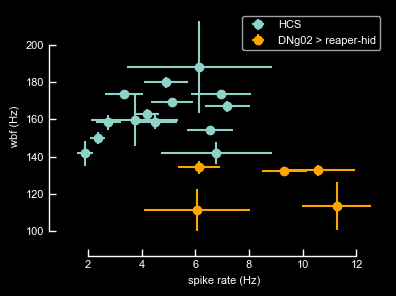

In [58]:
# plot
fig, ax = plt.subplots()

ax.errorbar(fly_dict_ctrl['spike_rate'], fly_dict_ctrl['wbf'], 
            xerr=fly_dict_ctrl['spike_rate_std'],
            yerr=fly_dict_ctrl['wbf_std'],
            label='HCS', 
            linestyle='none', 
            marker='o')

ax.errorbar(fly_dict_expr['spike_rate'], fly_dict_expr['wbf'], 
            xerr=fly_dict_expr['spike_rate_std'],
            yerr=fly_dict_expr['wbf_std'],
            label='DNg02 > reaper-hid', 
            linestyle='none',
            marker='o',
            color='orange')

ax.legend()
ax.set_xlabel('spike rate (Hz)')
ax.set_ylabel('wbf (Hz)')

my_adjust_axes(ax, trim_ticks_flag=False)
fig.tight_layout()
fig.savefig('wbf_vs_spike_rate_DNg02_ablation.png')